#### Seq2Seqとは
Seq2Seq(sequence to sequence)は、以下で説明するEncoderとDecoderを備えたEncoder-Decoderモデルを使って、系列データを別の系列データに変換するモデルのこと

#### Encoderとは
InputData(画像、テキスト、音声、動画etc)を何かしらの(固定長)特徴ベクトルに変換する機構のことを言います。
そのまんまですが、InputDataを抽象的なベクトルにエンコードしてるイメージ。

#### Decoderとは
Encoderでエンコードされた特徴ベクトルをデコードして何か新しいデータを生む機構のことをいいます。
OutputDataはInputDataと同じデータ形式である必要はなく、画像、テキスト、音声いろいろ

#### Encoder-Decoderモデルとは
EncoderとDecoderをつなげると、Encoder-Decoderモデルの完成
Encoder-Decoderモデルはいわゆる生成系のモデルであり、画像をテキストにしたり、音声からテキストを生成したり、日本語から英語（テキストから別のテキスト）に変換したりと用途は様々。
今回はこのSeq2Seqを使って系列データを別の系列データに変換するモデルを実装を通して解説

#### データの準備
引き算データセットの準備はどこかから入手する必要もなく、自前で準備すればOK。

In [1]:
%load_ext lab_black

In [2]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

# 数字の文字をID化
char2id = {str(i): i for i in range(10)}

# 空白(10)：系列の長さを揃えるようのパディング文字
# -(11)：マイナスの文字
# _(12)：系列生成開始を知らせる文字
char2id.update({" ": 10, "-": 11, "_": 12})

# 空白込みの３桁の数字をランダムに生成
def generate_number():
    number = [random.choice(list("0123456789")) for _ in range(random.randint(1, 3))]
    return int("".join(number))


# 確認
print(generate_number())

16


In [3]:
# 系列の長さを揃えるために空白パディング
def add_padding(number, is_input=True):
    number = "{: <7}".format(number) if is_input else "{: <5s}".format(number)
    return number


# 確認
num = generate_number()
print('"' + str(add_padding(num)) + '"')

"212    "


In [4]:
# データ準備
input_data = []
output_data = []

# データを５００００件準備する
while len(input_data) < 50000:
    x = generate_number()
    y = generate_number()
    z = x - y
    input_char = add_padding(str(x) + "-" + str(y))
    output_char = add_padding("_" + str(z), is_input=False)

    # データをIDにに変換
    input_data.append([char2id[c] for c in input_char])
    output_data.append([char2id[c] for c in output_char])

# 確認
print(input_data[987])
print(output_data[987])

[8, 2, 11, 8, 10, 10, 10]
[12, 7, 4, 10, 10]


In [5]:
# ７：３にデータをわける
train_x, test_x, train_y, test_y = train_test_split(
    input_data, output_data, train_size=0.7
)


# データをバッチ化するための関数
def train2batch(input_data, output_data, batch_size=100):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
        input_batch.append(input_shuffle[i : i + batch_size])
        output_batch.append(output_shuffle[i : i + batch_size])
    return input_batch, output_batch

#### モデル定義
- Encoder
- Encoderは簡単。隠れ層を返すだけでOK。

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim


embedding_dim = 200  # 文字の埋め込み次元数
hidden_dim = 128  # LSTMの隠れ層のサイズ
vocab_size = len(char2id)  # 扱う文字の数。今回は１３文字

# GPU使う用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoderクラス
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=char2id[" "]
        )
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        # Many to Oneなので、第２戻り値を使う
        _, state = self.lstm(embedding)
        # state = (h, c)
        return state

- Decoder
- Decoderの予測値は最大値をそのまま使えばいいので、softmaxは不要

In [7]:
# Decoderクラス
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=char2id[" "]
        )
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # LSTMの128次元の隠れ層を13次元に変換する全結合層
        self.hidden2linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, sequence, encoder_state):
        embedding = self.word_embeddings(sequence)
        # Many to Manyなので、第１戻り値を使う。
        # 第２戻り値は推論時に次の文字を生成するときに使います。
        output, state = self.lstm(embedding, encoder_state)
        output = self.hidden2linear(output)
        return output, state

#### モデル宣言、損失関数、最適化


In [8]:
# GPU使えるように。
encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

#### 学習

In [9]:
BATCH_NUM = 100
EPOCH_NUM = 100

all_losses = []
print("training ...")
for epoch in range(1, EPOCH_NUM + 1):
    epoch_loss = 0  # epoch毎のloss

    # データをミニバッチに分ける
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)

    for i in range(len(input_batch)):

        # 勾配の初期化
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)

        # Encoderの順伝搬
        encoder_state = encoder(input_tensor)

        # Decoderで使うデータはoutput_tensorを１つずらしたものを使う
        # Decoderのインプットとするデータ
        source = output_tensor[:, :-1]

        # Decoderの教師データ
        # 生成開始を表す"_"を削っている
        target = output_tensor[:, 1:]

        loss = 0
        # 学習時はDecoderはこのように１回呼び出すだけでグルっと系列をループしているからこれでOK
        # sourceが４文字なので、以下でLSTMが4回再帰的な処理してる
        decoder_output, _ = decoder(source, encoder_state)
        # decoder_output.size() = (100,4,13)
        # 「13」は生成すべき対象の文字が13文字あるから。decoder_outputの3要素目は
        # [-14.6240,  -3.7612, -11.0775,  ...,  -5.7391, -15.2419,  -8.6547]
        # こんな感じの値が入っており、これの最大値に対応するインデックスを予測文字とみなす

        for j in range(decoder_output.size()[1]):
            # バッチ毎にまとめてloss計算
            # 生成する文字は4文字なので、4回ループ
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()

        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        # Encoder、Decoder両方学習
        encoder_optimizer.step()
        decoder_optimizer.step()

    # 損失を表示
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    if epoch_loss < 1:
        break
print("Done")

training ...
Epoch 1: 1867.84
Epoch 2: 1357.92
Epoch 3: 1171.56
Epoch 4: 1043.47
Epoch 5: 950.89
Epoch 6: 869.63
Epoch 7: 794.90
Epoch 8: 713.12
Epoch 9: 641.19
Epoch 10: 568.59
Epoch 11: 508.42
Epoch 12: 456.14
Epoch 13: 409.89
Epoch 14: 371.99
Epoch 15: 344.13
Epoch 16: 319.73
Epoch 17: 298.36
Epoch 18: 280.74
Epoch 19: 261.86
Epoch 20: 243.94
Epoch 21: 232.54
Epoch 22: 214.79
Epoch 23: 204.59
Epoch 24: 193.75
Epoch 25: 184.09
Epoch 26: 172.26
Epoch 27: 164.41
Epoch 28: 161.77
Epoch 29: 147.67
Epoch 30: 146.47
Epoch 31: 135.73
Epoch 32: 133.70
Epoch 33: 122.27
Epoch 34: 117.42
Epoch 35: 122.91
Epoch 36: 113.32
Epoch 37: 99.75
Epoch 38: 105.60
Epoch 39: 101.92
Epoch 40: 93.16
Epoch 41: 89.68
Epoch 42: 88.13
Epoch 43: 91.70
Epoch 44: 92.61
Epoch 45: 81.21
Epoch 46: 67.62
Epoch 47: 67.07
Epoch 48: 77.73
Epoch 49: 75.48
Epoch 50: 60.91
Epoch 51: 61.70
Epoch 52: 67.64
Epoch 53: 61.96
Epoch 54: 63.43
Epoch 55: 55.63
Epoch 56: 46.90
Epoch 57: 52.01
Epoch 58: 63.12
Epoch 59: 39.74
Epoch 60: 

#### 損失可視化

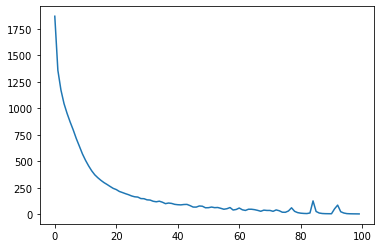

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(all_losses)

#### 予測

In [11]:
# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味する
def get_max_index(decoder_output):
    results = []
    for h in decoder_output:
        results.append(torch.argmax(h))
    return torch.tensor(results, device=device).view(BATCH_NUM, 1)


# 評価用データ
test_input_batch, test_output_batch = train2batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
    with torch.no_grad():  # 勾配計算させない
        encoder_state = encoder(input_tensor[i])

    # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
    start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
    decoder_input_tensor = torch.tensor(start_char_batch, device=device)

    # 変数名変換
    decoder_hidden = encoder_state

    # バッチ毎の結果を結合するための入れ物を定義
    batch_tmp = torch.zeros(100, 1, dtype=torch.long, device=device)
    # print(batch_tmp.size())
    # (100,1)

    for _ in range(5):
        decoder_output, decoder_hidden = decoder(decoder_input_tensor, decoder_hidden)
        # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
        decoder_input_tensor = get_max_index(decoder_output.squeeze())
        # バッチ毎の結果を予測順に結合
        batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)

    # 最初のbatch_tmpの0要素が先頭に残ってしまっているのでスライスして削除
    predicts.append(batch_tmp[:, 1:])

# バッチ毎の予測結果がまとまって格納されてます。
print(len(predicts))
print(predicts[0].size())

150
torch.Size([100, 5])


- 上でまとめたpredictsをDataFrameにまとめるための処理を以下で実行
- ついでにaccuracyも計算

In [12]:
import pandas as pd

id2char = {str(i): str(i) for i in range(10)}
id2char.update({"10": "", "11": "-", "12": ""})
row = []
for i in range(len(test_input_batch)):
    batch_input = test_input_batch[i]
    batch_output = test_output_batch[i]
    batch_predict = predicts[i]
    for inp, output, predict in zip(batch_input, batch_output, batch_predict):
        x = [id2char[str(idx)] for idx in inp]
        y = [id2char[str(idx)] for idx in output]
        p = [id2char[str(idx.item())] for idx in predict]

        x_str = "".join(x)
        y_str = "".join(y)
        p_str = "".join(p)

        judge = "O" if y_str == p_str else "X"
        row.append([x_str, y_str, p_str, judge])
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])

# 正解率を表示
print(len(predict_df.query('judge == "O"')) / len(predict_df))

# 間違えたデータを一部見てみる
print(predict_df.query('judge == "X"').head(10))

0.8605333333333334
      input answer predict judge
1    284-31    253     263     X
3    266-86    180     170     X
15   94-380   -286    -206     X
19  250-273    -23     -13     X
25  883-110    773     783     X
30  708-685     23       8     X
40    602-9    593     603     X
41   66-701   -635    -645     X
55   99-342   -243    -233     X
56   55-836   -781    -771     X
